# UTIL

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
!ls
!pip install optuna

forecasts_examples.png	test_pred.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import gc
import lightgbm as lgbm
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error
import imageio.v2 as imageio
from tqdm.notebook import tqdm
from itertools import product

import os
# os.chdir("drive/MyDrive")


pd.set_option('display.max_columns', 80)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# os.listdir("./")
df = pd.read_csv('/kaggle/input/industrial-ml-01/train_data.csv')
test = pd.read_excel('/kaggle/input/industrial-ml-01/test.xlsx')
test = test.iloc[:,0].str.split(",", expand=True)
test.columns = ["timestamp", "lat", "lon", "point", "sum", "error"]
test.head()

,timestamp,lat,lon,point,sum,error
0,1582711200,59.93486250245379,30.331615568295643,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.3702647438656909
1,1581937200,59.94048754777036,30.32936978008534,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735256134309
2,1581523200,59.90559688321354,30.29792874514116,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735256134309
3,1581512400,59.9213585004893,30.35631923860893,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.0880685894676425
4,1581771600,59.939362615035215,30.315895050823546,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.0880685894676425


In [5]:
df.dtypes

timestamp          int64
lon              float64
lat              float64
likescount         int64
commentscount      int64
symbols_cnt        int64
words_cnt          int64
hashtags_cnt       int64
mentions_cnt       int64
links_cnt          int64
emoji_cnt          int64
point             object
dtype: object

In [6]:
spb_edges = {'lat': (59.656929822910136, 60.374089897957774),
             'lon': (29.40635082565253, 32.047397760963925)}
df[['lon', 'lat']].agg(['max', 'min'])

,lon,lat
max,137.136811,60.374090
min,-48.410211,-1.390007


# PREPROCESSING AND AGGREGATION

In [7]:
for col in ('lat', 'lon'):
    df = df[(df[col] > spb_edges[col][0]) & (df[col] < spb_edges[col][1])]

In [8]:
un_lat = df.lat.unique()
un_lon = df.lon.unique()
print(len(un_lat), len(un_lon), len(df))

209 217 8450458


In [9]:
hyperparams = {
    'poly_cnt_threshold': 2000,
    'prediction_interval': 24*7*4, # known_lag
    'n_val_trials': 15,
    'metric': 'rmse'
}

In [10]:
poly = df.groupby(['lon', 'lat']).likescount.count().rename('post_cnt').reset_index()
poly = poly[poly["post_cnt"] > hyperparams['poly_cnt_threshold']][['lon', 'lat']]

In [11]:
df_new = pd.merge(df, poly, on=['lon', 'lat'])
print(len(df_new.timestamp.unique()))
df_new.head()

9504


,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.32937,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565571600,30.32937,59.940488,6,0,18,3,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
2,1565582400,30.32937,59.940488,12,0,169,3,10,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
3,1565582400,30.32937,59.940488,8,0,63,5,1,0,0,1,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
4,1565582400,30.32937,59.940488,110,2,26,3,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...


In [12]:
df_new.dtypes

timestamp          int64
lon              float64
lat              float64
likescount         int64
commentscount      int64
symbols_cnt        int64
words_cnt          int64
hashtags_cnt       int64
mentions_cnt       int64
links_cnt          int64
emoji_cnt          int64
point             object
dtype: object

In [13]:
feature_names = [
    'likescount',
    'commentscount',
    'symbols_cnt',
    'words_cnt',
    'hashtags_cnt',
    'mentions_cnt',
    'links_cnt',
    'emoji_cnt',
]

In [14]:
%%time
data = df_new.groupby(['timestamp', 'lon', 'lat'])[feature_names].agg([np.mean, np.std, np.min, np.max, 'count']).fillna(0)
data.columns = [f'{col1}_{col2}' for col1, col2 in data.columns]
data = data.rename(columns={'likescount_count': 'posts_count'})
data = data.drop(columns=[f'{feature}_count' for feature in feature_names if feature != 'likescount'])
data = data.reset_index()
data['datetime'] = data['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
data = data.set_index('datetime')
data = data.astype({"posts_count": "float64"})

data.head()

CPU times: user 16.3 s, sys: 4.46 s, total: 20.8 s
Wall time: 20.8 s


,timestamp,lon,lat,likescount_mean,likescount_std,likescount_amin,likescount_amax,posts_count,commentscount_mean,commentscount_std,commentscount_amin,commentscount_amax,symbols_cnt_mean,symbols_cnt_std,symbols_cnt_amin,symbols_cnt_amax,words_cnt_mean,words_cnt_std,words_cnt_amin,words_cnt_amax,hashtags_cnt_mean,hashtags_cnt_std,hashtags_cnt_amin,hashtags_cnt_amax,mentions_cnt_mean,mentions_cnt_std,mentions_cnt_amin,mentions_cnt_amax,links_cnt_mean,links_cnt_std,links_cnt_amin,links_cnt_amax,emoji_cnt_mean,emoji_cnt_std,emoji_cnt_amin,emoji_cnt_amax
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1546300800,30.136232,60.000054,52.000000,36.769553,26,78,2.0,1.000000,1.414214,0,2,28.000000,39.597980,0,56,0.500000,0.707107,0,1,2.000000,2.828427,0,4,0.0,0.0,0,0,0.0,0.0,0,0,0.500000,0.707107,0,1
2019-01-01,1546300800,30.138478,59.835705,32.000000,19.672316,11,50,3.0,0.333333,0.577350,0,1,46.000000,38.742741,10,87,2.333333,4.041452,0,7,3.000000,2.000000,1,5,0.0,0.0,0,0,0.0,0.0,0,0,1.333333,2.309401,0,4
2019-01-01,1546300800,30.142969,60.023627,77.666667,39.954140,33,110,3.0,3.333333,2.516611,1,6,34.666667,17.925773,14,46,2.666667,1.527525,1,4,0.666667,1.154701,0,2,0.0,0.0,0,0,0.0,0.0,0,0,1.666667,0.577350,1,2
2019-01-01,1546300800,30.142969,60.030359,19.000000,0.000000,19,19,1.0,3.000000,0.000000,3,3,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.000000,0.000000,0,0
2019-01-01,1546300800,30.142969,60.031480,13.857143,16.737469,4,51,7.0,0.285714,0.755929,0,2,8.000000,13.662601,0,28,0.714286,1.253566,0,3,0.000000,0.000000,0,0,0.0,0.0,0,0,0.0,0.0,0,0,2.428571,4.391550,0,11


In [15]:
data.dtypes

timestamp               int64
lon                   float64
lat                   float64
likescount_mean       float64
likescount_std        float64
likescount_amin         int64
likescount_amax         int64
posts_count           float64
commentscount_mean    float64
commentscount_std     float64
commentscount_amin      int64
commentscount_amax      int64
symbols_cnt_mean      float64
symbols_cnt_std       float64
symbols_cnt_amin        int64
symbols_cnt_amax        int64
words_cnt_mean        float64
words_cnt_std         float64
words_cnt_amin          int64
words_cnt_amax          int64
hashtags_cnt_mean     float64
hashtags_cnt_std      float64
hashtags_cnt_amin       int64
hashtags_cnt_amax       int64
mentions_cnt_mean     float64
mentions_cnt_std      float64
mentions_cnt_amin       int64
mentions_cnt_amax       int64
links_cnt_mean        float64
links_cnt_std         float64
links_cnt_amin          int64
links_cnt_amax          int64
emoji_cnt_mean        float64
emoji_cnt_

In [16]:
# %%time
# data_full = df.groupby(['timestamp', 'lon', 'lat'])[feature_names].agg([np.mean, np.std, np.min, np.max, 'count']).fillna(0)
# data_full.columns = [f'{col1}_{col2}' for col1, col2 in data_full.columns]
# data_full = data_full.rename(columns={'likescount_count': 'posts_count'})
# data_full = data_full.drop(columns=[f'{feature}_count' for feature in feature_names if feature != 'likescount'])
# data_full = data_full.reset_index()
# data_full['datetime'] = data_full['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
# data_full = data_full.set_index('datetime')

# data_full.head()

# TEST DATA

In [17]:
test_data = test[['timestamp', 'lat', 'lon']].copy()
test_data['posts_count'] = [np.nan]*len(test_data)
test_data['datetime'] = test_data['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(int(x)))
test_data = test_data.set_index('datetime')
test_data = test_data.sort_index()
test_data = test_data.astype({"timestamp": "int64", "lat": "float64", "lon": "float64"})
test_data.head()

,timestamp,lat,lon,posts_count
datetime,,,,
2020-02-01 06:00:00,1580536800,59.931487,30.354073,NaN
2020-02-01 06:00:00,1580536800,59.893208,30.515770,NaN
2020-02-01 08:00:00,1580544000,59.921359,30.356319,NaN
2020-02-01 10:00:00,1580551200,59.982083,30.199114,NaN
2020-02-01 10:00:00,1580551200,60.039332,30.322632,NaN


In [18]:
test_data.dtypes

timestamp        int64
lat            float64
lon            float64
posts_count    float64
dtype: object

In [19]:
full_data = pd.concat([data, test_data])
full_data.tail()

,timestamp,lon,lat,likescount_mean,likescount_std,likescount_amin,likescount_amax,posts_count,commentscount_mean,commentscount_std,commentscount_amin,commentscount_amax,symbols_cnt_mean,symbols_cnt_std,symbols_cnt_amin,symbols_cnt_amax,words_cnt_mean,words_cnt_std,words_cnt_amin,words_cnt_amax,hashtags_cnt_mean,hashtags_cnt_std,hashtags_cnt_amin,hashtags_cnt_amax,mentions_cnt_mean,mentions_cnt_std,mentions_cnt_amin,mentions_cnt_amax,links_cnt_mean,links_cnt_std,links_cnt_amin,links_cnt_amax,emoji_cnt_mean,emoji_cnt_std,emoji_cnt_amin,emoji_cnt_amax
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29 19:00:00,1583002800,30.468609,59.921359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 19:00:00,1583002800,30.342845,59.934863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 19:00:00,1583002800,30.338353,60.022505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 20:00:00,1583006400,30.241784,59.924735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 21:00:00,1583010000,30.295683,59.925860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
full_data.dtypes

timestamp               int64
lon                   float64
lat                   float64
likescount_mean       float64
likescount_std        float64
likescount_amin       float64
likescount_amax       float64
posts_count           float64
commentscount_mean    float64
commentscount_std     float64
commentscount_amin    float64
commentscount_amax    float64
symbols_cnt_mean      float64
symbols_cnt_std       float64
symbols_cnt_amin      float64
symbols_cnt_amax      float64
words_cnt_mean        float64
words_cnt_std         float64
words_cnt_amin        float64
words_cnt_amax        float64
hashtags_cnt_mean     float64
hashtags_cnt_std      float64
hashtags_cnt_amin     float64
hashtags_cnt_amax     float64
mentions_cnt_mean     float64
mentions_cnt_std      float64
mentions_cnt_amin     float64
mentions_cnt_amax     float64
links_cnt_mean        float64
links_cnt_std         float64
links_cnt_amin        float64
links_cnt_amax        float64
emoji_cnt_mean        float64
emoji_cnt_

In [21]:
def add_features(df, featue_cols):
    def get_sin_cos(col, period, name):
        return pd.DataFrame(
            {f'{name}_sin': np.sin(col / period * 2 * np.pi),
             f'{name}_cos': np.cos(col / period * 2 * np.pi)})

    # time features
    hour_features = get_sin_cos(df.index.hour, 24, 'hour').set_index(df.index)
    week_features = get_sin_cos(df.index.weekday, 7, 'weekday').set_index(df.index)
    year_features = get_sin_cos(df.index.day_of_year, 365, 'yearday').set_index(df.index)

    # lag features
    dates_lag_stats = df.groupby(df.index)[featue_cols].agg(['max', 'mean', 'min', 'std']).shift(hyperparams['prediction_interval'])
    dates_lag_stats.columns = [f'lag_{name1}_{name2}' for name1, name2 in dates_lag_stats.columns]

    df = df.merge(dates_lag_stats, left_index=True, right_index=True)
    return pd.concat([df, hour_features, week_features, year_features], axis=1)

In [22]:
print(full_data.columns)
feature_columns = full_data.columns[3:]

Index(['timestamp', 'lon', 'lat', 'likescount_mean', 'likescount_std',
       'likescount_amin', 'likescount_amax', 'posts_count',
       'commentscount_mean', 'commentscount_std', 'commentscount_amin',
       'commentscount_amax', 'symbols_cnt_mean', 'symbols_cnt_std',
       'symbols_cnt_amin', 'symbols_cnt_amax', 'words_cnt_mean',
       'words_cnt_std', 'words_cnt_amin', 'words_cnt_amax',
       'hashtags_cnt_mean', 'hashtags_cnt_std', 'hashtags_cnt_amin',
       'hashtags_cnt_amax', 'mentions_cnt_mean', 'mentions_cnt_std',
       'mentions_cnt_amin', 'mentions_cnt_amax', 'links_cnt_mean',
       'links_cnt_std', 'links_cnt_amin', 'links_cnt_amax', 'emoji_cnt_mean',
       'emoji_cnt_std', 'emoji_cnt_amin', 'emoji_cnt_amax'],
      dtype='object')


In [23]:
%%time
full_data = add_features(full_data, feature_columns).drop(columns=feature_columns[feature_columns != 'posts_count'])

CPU times: user 6.35 s, sys: 3.5 s, total: 9.84 s
Wall time: 9.86 s


In [24]:
full_data.dtypes

timestamp                    int64
lon                        float64
lat                        float64
posts_count                float64
lag_likescount_mean_max    float64
                            ...   
hour_cos                   float64
weekday_sin                float64
weekday_cos                float64
yearday_sin                float64
yearday_cos                float64
Length: 142, dtype: object

In [25]:
train_data = full_data.iloc[:len(data)]
test_data = full_data.iloc[len(data):]

In [26]:
val_start = dt.datetime(2020, 1, 10, 0)
columns = train_data.columns
features = columns[columns != 'posts_count']
target = 'posts_count'

train_x = train_data.loc[:val_start - dt.timedelta(hours=1), features]
val_x = train_data.loc[val_start:, features]
train_y = np.log(train_data.loc[:val_start - dt.timedelta(hours=1), target].astype('float'))
val_y = np.log(train_data.loc[val_start:, target].astype('float'))

In [27]:
val_x.index.max() - val_x.index.min()

Timedelta('21 days 23:00:00')

In [28]:
train = lgbm.Dataset(train_x, train_y)
val = lgbm.Dataset(val_x, val_y)

In [29]:
def objective(trial):
    params = {}
    params['num_leaves'] = trial.suggest_int('num_leaves', 2, 512)
    params['max_depth'] = trial.suggest_int('max_depth', 4, 32)
    params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 16)
    params['feature_fraction'] = trial.suggest_uniform('feature_fraction', 0.4, 1.0)
    params['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.4, 1.0)
    params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 8)
    params['lambda_l1'] = trial.suggest_loguniform('lambda_l1', 1e-8, 1.0)
    params['lambda_l2'] = trial.suggest_loguniform('lambda_l2', 1e-8, 1.0)
    params['num_boost_round'] = trial.suggest_int('num_boost_round', 10, 500)
    params.update({
        'metric': hyperparams['metric'],
        'boosting_type': 'gbdt',
        'early_stopping_rounds': 10,
        'verbosity': -1,
        'random_state': 42,
    })

    model = lgbm.train(params, train, valid_sets=[val], verbose_eval=False)
    return model.best_score['valid_0'][hyperparams['metric']]

In [30]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,
    n_trials=hyperparams['n_val_trials'],
)

[I 2023-10-18 11:03:20,804] A new study created in memory with name: no-name-4b4dfd63-c9d0-4ed1-9d5e-5073482ed522
[I 2023-10-18 11:06:03,547] Trial 0 finished with value: 0.5643411341632996 and parameters: {'num_leaves': 390, 'max_depth': 24, 'min_child_weight': 1, 'feature_fraction': 0.5673654595419654, 'bagging_fraction': 0.6488559498587929, 'bagging_freq': 4, 'lambda_l1': 2.4626836996707894e-08, 'lambda_l2': 0.00035226593805465635, 'num_boost_round': 435}. Best is trial 0 with value: 0.5643411341632996.
[I 2023-10-18 11:08:34,323] Trial 1 finished with value: 0.5518401683417753 and parameters: {'num_leaves': 226, 'max_depth': 24, 'min_child_weight': 16, 'feature_fraction': 0.9934611052045375, 'bagging_fraction': 0.6128805113639049, 'bagging_freq': 8, 'lambda_l1': 2.5122879684869575e-08, 'lambda_l2': 1.5187071196973544e-07, 'num_boost_round': 482}. Best is trial 1 with value: 0.5518401683417753.
[I 2023-10-18 11:12:03,695] Trial 2 finished with value: 0.5589281091307188 and parameter

In [31]:
pd.DataFrame.from_dict(study.best_params, orient='index').rename(columns={0: 'lgbm hyperparams'})

,lgbm hyperparams
num_leaves,4.390000e+02
max_depth,1.600000e+01
min_child_weight,1.600000e+01
feature_fraction,9.949305e-01
bagging_fraction,9.818946e-01
bagging_freq,7.000000e+00
lambda_l1,4.000640e-06
lambda_l2,1.390685e-08
num_boost_round,4.960000e+02


In [32]:
params = {
    "metric": "rmse",
    "boosting_type": "gbdt",
    "early_stopping_rounds": 10,
    "verbosity": -1,
    "random_state": 69,
}

In [33]:
params.update(study.best_params)
params

{'metric': 'rmse',
 'boosting_type': 'gbdt',
 'early_stopping_rounds': 10,
 'verbosity': -1,
 'random_state': 69,
 'num_leaves': 439,
 'max_depth': 16,
 'min_child_weight': 16,
 'feature_fraction': 0.9949305440850388,
 'bagging_fraction': 0.9818946170515921,
 'bagging_freq': 7,
 'lambda_l1': 4.000639588977452e-06,
 'lambda_l2': 1.3906853755407818e-08,
 'num_boost_round': 496}

In [51]:
model = lgbm.train(params, train, valid_sets=[val], verbose_eval=False)

In [52]:
preds = np.exp(model.predict(val_x))
print('Validation MAE: ' + str(mean_absolute_error(np.exp(val_y), preds)))

Validation MAE: 1.431219105257986


In [53]:
test_data.dtypes

timestamp                    int64
lon                        float64
lat                        float64
posts_count                float64
lag_likescount_mean_max    float64
                            ...   
hour_cos                   float64
weekday_sin                float64
weekday_cos                float64
yearday_sin                float64
yearday_cos                float64
Length: 142, dtype: object

In [54]:
test_num = test.astype({
    "timestamp": "int64",
    "lat": "float64",
    "lon": "float64",
    "sum": "float64",
    "error": "float64",
})

In [55]:
final_result = test_data.merge(test_num[['timestamp', 'lon', 'lat', 'sum']], on=['timestamp', 'lon', 'lat'])

In [56]:
preds = np.exp(model.predict(final_result[features]))

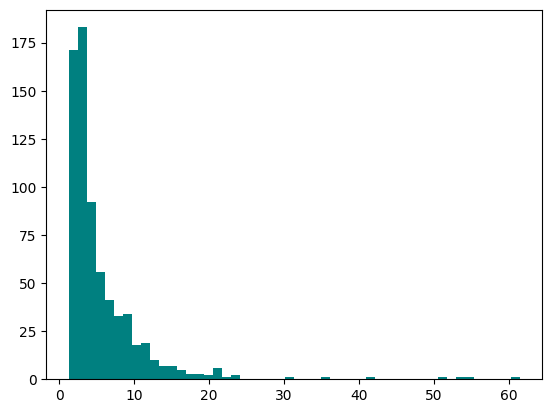

In [57]:
plt.hist(preds, bins=50, color="teal");

In [58]:
final_result['pred'] = np.round(np.maximum(preds, 5))

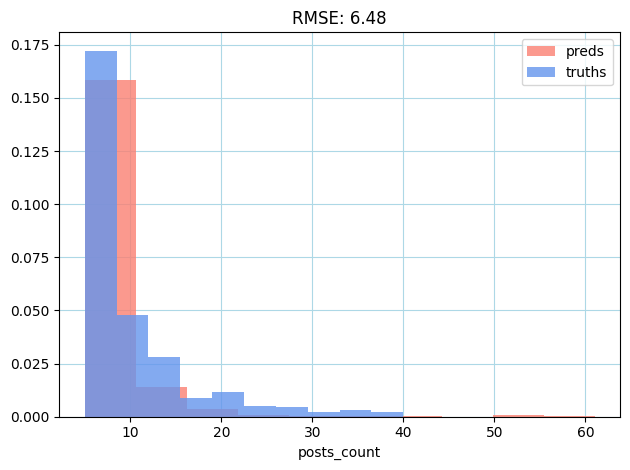

In [59]:
fig, ax = plt.subplots()

rmse = np.sqrt(np.mean((final_result['pred'] - final_result['sum'])**2))
custom_metric = ((final_result['pred'] - final_result['sum']).abs() / final_result['pred']).mean()

ax.hist(final_result['pred'], alpha=0.8, color='salmon', zorder=2, label='preds', density=True)
ax.hist(final_result['sum'], alpha=0.8, color='cornflowerblue', zorder=2, label='truths', density=True)
ax.grid(color='lightblue', zorder=0)
ax.legend()
ax.set_xlabel('posts_count')
ax.set_title(f'RMSE: {rmse:.2f}') #, custom metric: {custom_metric:.2f}
fig.tight_layout()

In [60]:
final_result[['timestamp', 'lon', 'lat', 'pred']].to_csv('test_pred.csv')

In [61]:
final_result

,timestamp,lon,lat,posts_count,lag_likescount_mean_max,lag_likescount_mean_mean,lag_likescount_mean_min,lag_likescount_mean_std,lag_likescount_std_max,lag_likescount_std_mean,lag_likescount_std_min,lag_likescount_std_std,lag_likescount_amin_max,lag_likescount_amin_mean,lag_likescount_amin_min,lag_likescount_amin_std,lag_likescount_amax_max,lag_likescount_amax_mean,lag_likescount_amax_min,lag_likescount_amax_std,lag_posts_count_max,lag_posts_count_mean,lag_posts_count_min,lag_posts_count_std,lag_commentscount_mean_max,lag_commentscount_mean_mean,lag_commentscount_mean_min,lag_commentscount_mean_std,lag_commentscount_std_max,lag_commentscount_std_mean,lag_commentscount_std_min,lag_commentscount_std_std,lag_commentscount_amin_max,lag_commentscount_amin_mean,lag_commentscount_amin_min,lag_commentscount_amin_std,lag_commentscount_amax_max,lag_commentscount_amax_mean,lag_commentscount_amax_min,lag_commentscount_amax_std,...,lag_links_cnt_mean_max,lag_links_cnt_mean_mean,lag_links_cnt_mean_min,lag_links_cnt_mean_std,lag_links_cnt_std_max,lag_links_cnt_std_mean,lag_links_cnt_std_min,lag_links_cnt_std_std,lag_links_cnt_amin_max,lag_links_cnt_amin_mean,lag_links_cnt_amin_min,lag_links_cnt_amin_std,lag_links_cnt_amax_max,lag_links_cnt_amax_mean,lag_links_cnt_amax_min,lag_links_cnt_amax_std,lag_emoji_cnt_mean_max,lag_emoji_cnt_mean_mean,lag_emoji_cnt_mean_min,lag_emoji_cnt_mean_std,lag_emoji_cnt_std_max,lag_emoji_cnt_std_mean,lag_emoji_cnt_std_min,lag_emoji_cnt_std_std,lag_emoji_cnt_amin_max,lag_emoji_cnt_amin_mean,lag_emoji_cnt_amin_min,lag_emoji_cnt_amin_std,lag_emoji_cnt_amax_max,lag_emoji_cnt_amax_mean,lag_emoji_cnt_amax_min,lag_emoji_cnt_amax_std,hour_sin,hour_cos,weekday_sin,weekday_cos,yearday_sin,yearday_cos,sum,pred
0,1580536800,30.354073,59.931487,NaN,2071.0,68.211198,1.0,200.219531,3546.422282,54.229887,0.0,340.996402,279.0,35.469565,0.0,46.408809,6166.0,139.991304,1.0,606.713240,17.0,1.956522,1.0,2.202038,15.200000,1.208596,0.0,2.403546,32.337285,0.841384,0.0,3.473525,11.0,0.686957,0.0,1.591453,73.0,2.330435,0.0,7.497042,...,0.2,0.001739,0.0,0.018650,0.447214,0.003889,0.0,0.041703,0.0,0.000000,0.0,0.000000,1.0,0.008696,0.0,0.093250,18.0,1.631927,0.0,3.364731,14.142136,0.890502,0.0,2.585348,18.0,1.069565,0.0,3.068578,42.0,2.860870,0.0,6.460252,1.000000,6.123234e-17,-0.974928,-0.222521,0.523416,0.852078,7.0,5.0
1,1580536800,30.515770,59.893208,NaN,2071.0,68.211198,1.0,200.219531,3546.422282,54.229887,0.0,340.996402,279.0,35.469565,0.0,46.408809,6166.0,139.991304,1.0,606.713240,17.0,1.956522,1.0,2.202038,15.200000,1.208596,0.0,2.403546,32.337285,0.841384,0.0,3.473525,11.0,0.686957,0.0,1.591453,73.0,2.330435,0.0,7.497042,...,0.2,0.001739,0.0,0.018650,0.447214,0.003889,0.0,0.041703,0.0,0.000000,0.0,0.000000,1.0,0.008696,0.0,0.093250,18.0,1.631927,0.0,3.364731,14.142136,0.890502,0.0,2.585348,18.0,1.069565,0.0,3.068578,42.0,2.860870,0.0,6.460252,1.000000,6.123234e-17,-0.974928,-0.222521,0.523416,0.852078,8.0,5.0
2,1580544000,30.356319,59.921359,NaN,382.0,49.436420,1.0,66.824570,109.308432,9.047307,0.0,20.684583,382.0,42.639535,0.0,68.145331,382.0,59.313953,1.0,72.576007,21.0,1.906977,1.0,2.485856,40.000000,1.581977,0.0,4.746086,6.500000,0.236848,0.0,0.849761,40.0,1.430233,0.0,4.766404,40.0,1.895349,0.0,4.939705,...,1.0,0.015504,0.0,0.113264,0.577350,0.006713,0.0,0.062257,1.0,0.011628,0.0,0.107833,1.0,0.023256,0.0,0.151599,48.0,2.350263,0.0,6.743037,5.678908,0.335761,0.0,1.044788,48.0,2.081395,0.0,6.746180,48.0,2.744186,0.0,6.925122,0.866025,-5.000000e-01,-0.974928,-0.222521,0.523416,0.852078,13.0,5.0
3,1580551200,30.199114,59.982083,NaN,285.0,47.520056,0.0,60.396173,380.423448,15.343105,0.0,52.925176,249.0,35.898305,0.0,51.954123,554.0,60.966102,0.0,87.579317,10.0,1.576271,1.0,1.464563,14.000000,1.338983,0.0,2.681704,10.606602,0.545180,0.0,1.808068,14.0,0.949153,0.0,2.494295,15.0,1.864407,0.0,3.496095,...,1.0,0.016949,0.0,0.130189,0.000000,0.000000,0.0,0.000000,1.0,0.016949,0.0,0.130189,1.0,0.016949,0.0,0.130189,74.5,2.417232,0.0,9.8

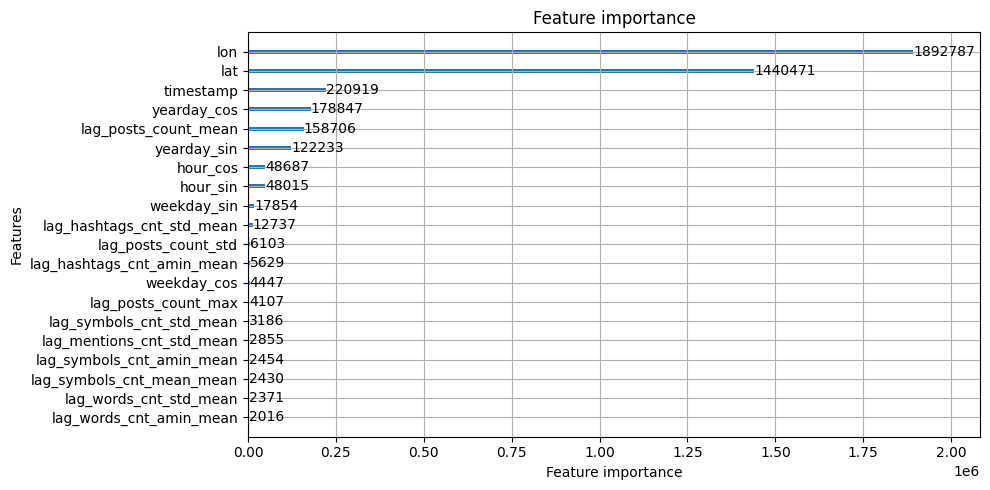

In [62]:
ax = lgbm.plot_importance(model, importance_type='gain', figsize=(10,5), max_num_features=20, precision=0)
plt.tight_layout()

In [63]:
dates = pd.DataFrame(pd.date_range(dt.datetime(2020, 2, 1, 0), dt.datetime(2020, 2, 28, 23), freq='H'), columns=['datetime'])
dates['key'] = 0
poly['key'] = 0

new_test = poly.merge(dates).drop(columns=['key']).set_index('datetime').sort_index()
new_test['timestamp'] = new_test.index.astype('int64') // 10 ** 9
new_test = new_test[['timestamp', 'lon', 'lat']]
new_test['posts_count'] = [np.nan]*len(new_test)
new_test

,timestamp,lon,lat,posts_count
datetime,,,,
2020-02-01 00:00:00,1580515200,30.104791,59.995563,NaN
2020-02-01 00:00:00,1580515200,30.342845,59.933737,NaN
2020-02-01 00:00:00,1580515200,30.304666,59.942737,NaN
2020-02-01 00:00:00,1580515200,30.574161,59.824419,NaN
2020-02-01 00:00:00,1580515200,30.493312,59.853756,NaN
...,...,...,...,...
2020-02-28 23:00:00,1582930800,30.347336,59.914604,NaN
2020-02-28 23:00:00,1582930800,30.347336,59.832320,NaN
2020-02-28 23:00:00,1582930800,30.345090,59.984330,NaN


In [64]:
new_full_data = pd.concat([data, new_test])
new_full_data = add_features(new_full_data, feature_columns)
new_test = new_full_data.iloc[-len(new_test):]

new_preds = np.around(np.exp(model.predict(new_test[features])))
new_test['preds'] = new_preds

In [65]:
tmp = train_data[train_data.index >= dt.datetime(2020, 1, 1, 0)]
lonlat = tmp.groupby(['lon', 'lat']).posts_count.sum().sort_values().reset_index()
lonlat = lonlat[lonlat.posts_count > 200].reset_index(drop=True)

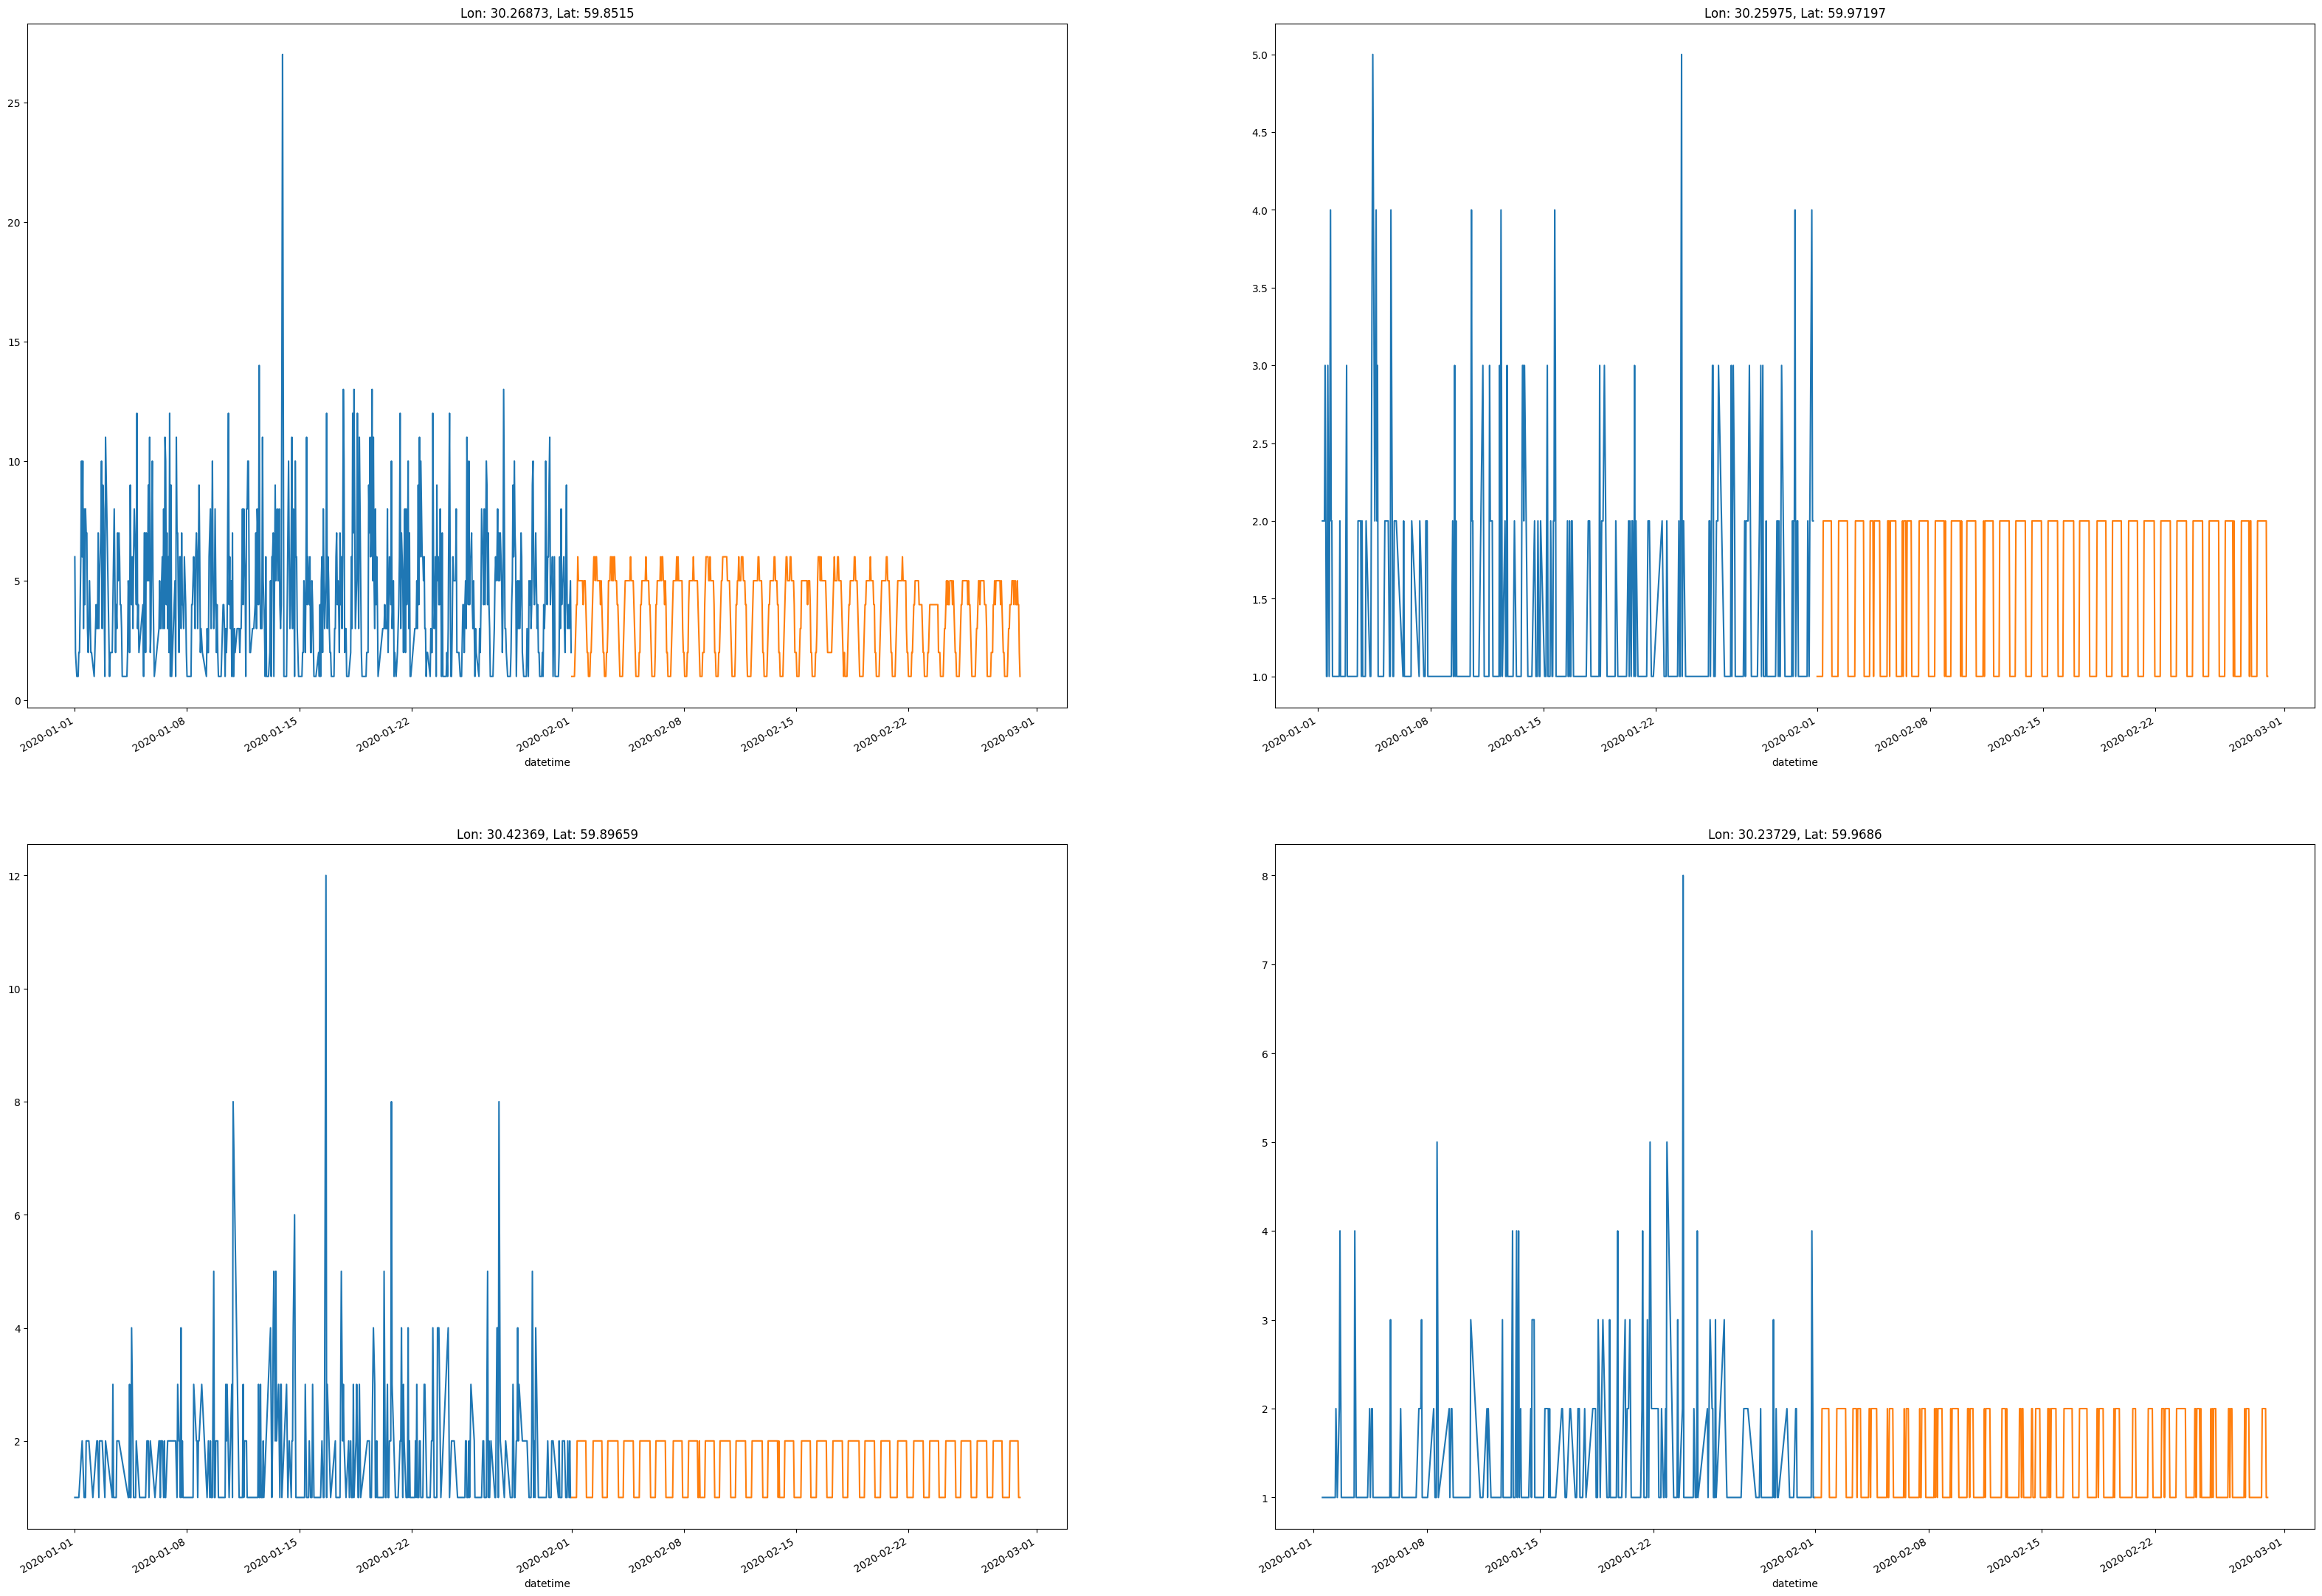

In [67]:
plt.figure(figsize=(40, 30))
for i in range(4):
    plt.subplot(2, 2, i+1)
    cur_poly = np.random.randint(0, len(lonlat))
    tmp[(tmp.lon == lonlat.loc[cur_poly][0]) & (tmp.lat == lonlat.loc[cur_poly][1])].posts_count.plot()
    new_test[(new_test.lon == lonlat.loc[cur_poly][0]) & (new_test.lat == lonlat.loc[cur_poly][1])].preds.plot()
    plt.title(f"Lon: {round(lonlat.loc[cur_poly][0], 5)}, Lat: {round(lonlat.loc[cur_poly][1], 5)}")
plt.savefig('forecasts_examples.png', bbox_inches='tight')